In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd /content/gdrive/MyDrive/SLIIT/Research Project/

/content/gdrive/MyDrive/SLIIT/Research Project


In [3]:
#import relevant libraries
import numpy as np
import pandas as pd

#import the csv file to extract data
df=pd.read_csv('Money_printing.csv')
df=df.dropna() #drop null values
print('Shape of data',df.shape)
df.info()
df.head()

Shape of data (325, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Month           325 non-null    object
 1   Money_Printing  325 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


,Month,Money_Printing
0,Dec-95,"38,662"
1,Jan-96,"40,795"
2,Feb-96,"40,238"
3,Mar-96,"43,617"
4,Apr-96,"43,090"


We have to convert the 'Net Credit granted to the Government (NCG)' column's datatype into float.

In [4]:
# define a function to remove comma and convert to float
def remove_comma_and_convert_to_float(s):
    s = s.replace(',', '')
    f = float(s)
    return f


#apply the function to the entire column
df['Money_Printing'] = df['Money_Printing'].apply(remove_comma_and_convert_to_float)

#drop duplicates
dup_sum=df.duplicated(subset='Month').sum()
print(dup_sum)

0


No duplicates available.

Date structure is different in some records in 'Month' column, so we have to reformat them & then we have to convert the string datatype to datetime of the 'Month' column.

Using the following code I am trying to extract the dates that are in a different format (mm-yy) compared to the majority of others.

In [5]:
import re

# Replace the additional parts with an empty string since Month records contain additional simbols & letters.
df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')

# Trim any leading/trailing whitespace characters
df['Month'] = df['Month'].str.strip()

date_pattern = r'\b\w{3}-\d{2}\b'
mm_yy_dates = [date for date in df['Month'] if re.match(date_pattern, date)] #Take all the elements that are in the format of mm-yy.

<ipython-input-5-9cfdb479612c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Month'] = df['Month'].str.replace(r'(\s*\(\w+\))', '')


Now lets try to convert the mm-yy dates into yy-mm preprocess the dataset.

In [6]:
import datetime

# Define the function to convert month-year dates into year-month
def convert_month_date(date_str):
  month = date_str[:3]  # Extract the first two characters as month
  year = date_str[-2:]  # Extract the last two characters as year
  date_str = year + '-' + month  # Reformat the date string as yy-mm
  print(date_str)
  return date_str

# calling the function
converted_dates = [convert_month_date(date) for date in mm_yy_dates]

# Iterate over mm_yy_dates and replace the values in the DataFrame with the values in converted_dates where we have the dates with corrected format. (yy-mm)
for mm_yy_date in mm_yy_dates:
    mm_yy_month, mm_yy_year = mm_yy_date.split('-')  # Split the mm-yy date into month and year
    print("month : " + mm_yy_month + "year : " + mm_yy_year )
    converted_date = next((date for date in converted_dates if date[-3:] == mm_yy_month and date[:2] == mm_yy_year), None)
    print("converted date : " + converted_date)
    if converted_date:
      df.loc[df['Month'] == mm_yy_date, 'Month'] = converted_date

95-Dec
96-Jan
96-Feb
96-Mar
96-Apr
96-May
96-Jun
96-Jul
96-Aug
96-Sep
96-Oct
96-Nov
96-Dec
97-Jan
97-Feb
97-Mar
97-Apr
97-May
97-Jun
97-Jul
97-Aug
97-Sep
97-Oct
97-Nov
97-Dec
98-Jan
98-Feb
98-Mar
98-Apr
98-May
98-Jun
98-Jul
98-Aug
98-Sep
98-Oct
98-Nov
98-Dec
99-Jan
99-Feb
99-Mar
99-Apr
99-May
99-Jun
99-Jul
99-Aug
99-Sep
99-Oct
99-Nov
99-Dec
00-Jan
00-Feb
00-Mar
00-Apr
00-May
00-Jun
00-Jul
00-Aug
00-Sep
00-Oct
00-Nov
00-Dec
15-Oct
22-Mar
22-Apr
22-May
22-Oct
month : Decyear : 95
converted date : 95-Dec
month : Janyear : 96
converted date : 96-Jan
month : Febyear : 96
converted date : 96-Feb
month : Maryear : 96
converted date : 96-Mar
month : Apryear : 96
converted date : 96-Apr
month : Mayyear : 96
converted date : 96-May
month : Junyear : 96
converted date : 96-Jun
month : Julyear : 96
converted date : 96-Jul
month : Augyear : 96
converted date : 96-Aug
month : Sepyear : 96
converted date : 96-Sep
month : Octyear : 96
converted date : 96-Oct
month : Novyear : 96
converted date : 96-No

In [ ]:
df.shape

(325, 2)

We have to convert the date column's datatype into datetime.

In [7]:
#Add 0 for years where only one digit exists.
df['Month'] = df['Month'].str.replace(r'\b(\d{1})\b', r'0\1', regex=True)

#change the datatype into datetime
df['Month'] = pd.to_datetime(df['Month'], format='%y-%b')

In [8]:
from sklearn.preprocessing import MinMaxScaler


# Create a Min-Max scaler
scaler = MinMaxScaler()

# Fit and transform the 'Money_Printing' column
df['Money_Printing'] = scaler.fit_transform(df['Money_Printing'].values.reshape(-1, 1))

Now the dataset is preprocessed.

Now we have to test whether the data set is stationary or not. Use Augmented Dick-fuller (ADF) for that.

    null hypotheis : the series is non-stationary
    alternative hypothesis : the series is stationary


In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Money_Printing'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.317868
p-value: 1.000000


As the p-value is greater than 0.05, the null hypothesis cannot be rejected at a significant level of 95%. So the tme series is not stationary.

In [10]:
#differentite the timeseries
df['Money_Printing']= df['Money_Printing'].diff().diff()
result = adfuller(df['Money_Printing'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.900694
p-value: 0.000000


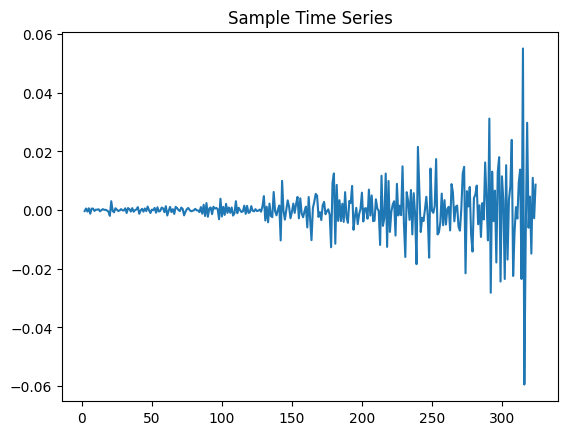

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# plot the time series
plt.plot(df['Money_Printing'])
plt.title('Sample Time Series')
plt.show()

The time series is non-stationary. Let us check the seasnality as well.

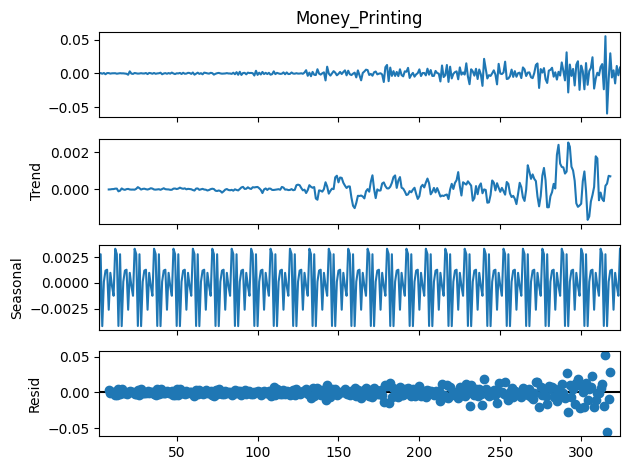

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

#makesure no null values in df['Money_Printing']
df=df.dropna()

# Perform seasonal decomposition using moving averages
decomposition = seasonal_decompose(df['Money_Printing'], model='additive', period=12)

# Plot the seasonal decomposition
fig = decomposition.plot()

There is a seasonal component because we can see a repeating pattern in seasonal component.

Residual distribution has no patterns & its random. So thats not a problem.

No trend.

So, now to remove the seasonality, lets use SARIMA. Before that we need to identify the exact seasonal period of the time series. lets plot the ACF & PACF plots in order to do that.

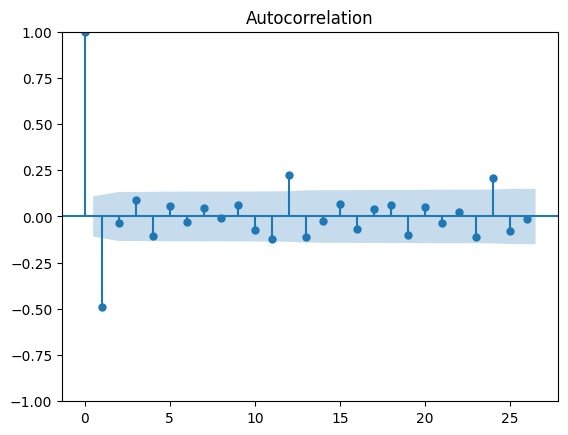

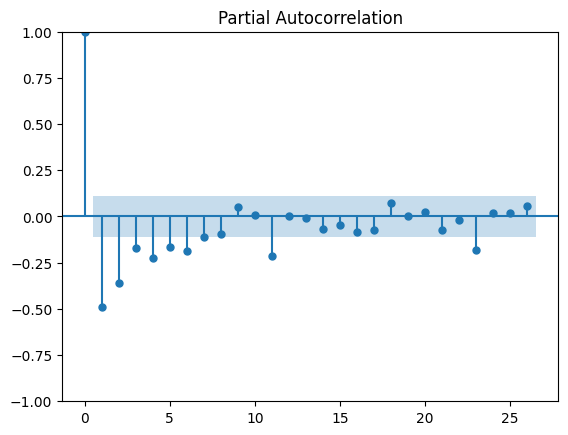

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(df['Money_Printing'])
plot_pacf(df['Money_Printing'])
plt.show()


As the significant lags appear at 1 & 12, the seasnal period can be taken as 12. if the PACF contains 12 significnat spikes, thats a strng indicatin that the seasnal period is 12. But here, we can only see 8 significant spikes.  

Using these two plots, SARIMA parameters can be determined.

SARIMA (8,2,3)(2,2,2,12) since ACF plot has random significant spikes.

NOw let us train the SARIMAX model.

Lets use some other methods to determine SARIMA parameters.

In [14]:
#install pmdarima
!pip install pmdarima


from pmdarima.arima import auto_arima

# Perform grid search
model = auto_arima(df['Money_Printing'], seasonal=True, m=12, suppress_warnings=True)

# Print the best parameters found
print("Best SARIMA parameters:", model.order, model.seasonal_order)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00
Best SARIMA parameters: (0, 0, 1) (0, 0, 2, 12)


Lets fit the model based on the determined p,d,q, P,D,Q values.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Month'>

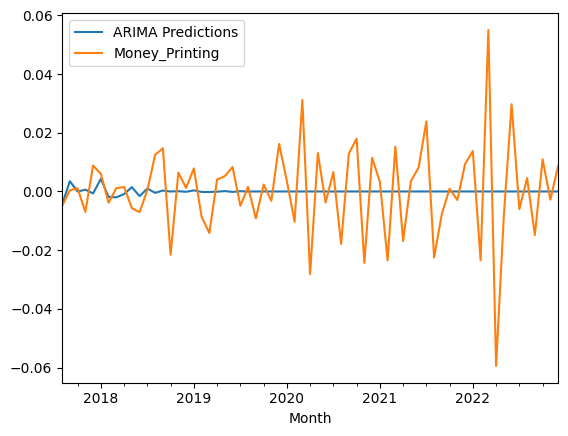

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import pickle

# Set 'Dates' column as the index
df.set_index('Month', inplace=True)

# Split the data into train and test sets
train, test = train_test_split(df['Money_Printing'], test_size=0.2, shuffle=False)

# Fit the SARIMA model
model = SARIMAX(train, order=(0,0,1), seasonal_order=(0, 0, 2, 12))
#model = SARIMAX(train, order=(1, 2, 2), seasonal_order=(2, 0, 0, 12))
fitted_model = model.fit()

# Save the sarima model to a pickle file
with open('Money_printing.pkl', 'wb') as file:
    pickle.dump(fitted_model, file)


# Generate predictions
start = len(train)
end = len(train) + len(test) - 1
pred = fitted_model.predict(start=start, end=end, typ='levels').rename('ARIMA Predictions')

# Plot the predictions and actual values
pred.plot(legend=True)
test.plot(legend=True)




In [ ]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Money_Printing   No. Observations:                  258
Model:             SARIMAX(2, 0, 3)x(2, 0, [1], 12)   Log Likelihood               -2985.216
Date:                              Tue, 05 Sep 2023   AIC                           5988.433
Time:                                      17:44:05   BIC                           6020.409
Sample:                                  02-01-1996   HQIC                          6001.291
                                       - 07-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2971      0.853     -0.348      0.728      -1.968       1.374
ar.L2          0.4725      0.605      0.781      0.435      -0.713       1.658
ma.L1         -0.5601      0.871     -0.643      0.520      -2.267       1.146
ma.L2         -0.8448      0.309     -2.737      0.006      -1.450      -0.240
ma.L3          0.4202      0.669      0.628      0.530      -0.891       1.732
ar.S.L12       0.5631      0.327      1.724      0.085      -0.077       1.203
ar.S.L24       0.1219      0.109      1.123      0.262      -0.091       0.335
ma.S.L12      -0.3522      0.343     -1.026      0.305      -1.025       0.321
sigma2      8.039e+08   8.35e-09   9.63e+16      0.000    8.04e+08    8.04e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               332.26
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):              75.17   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+34. Standard errors may be unstable.
"""

Lets predict the testing data & check the model.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='Month'>

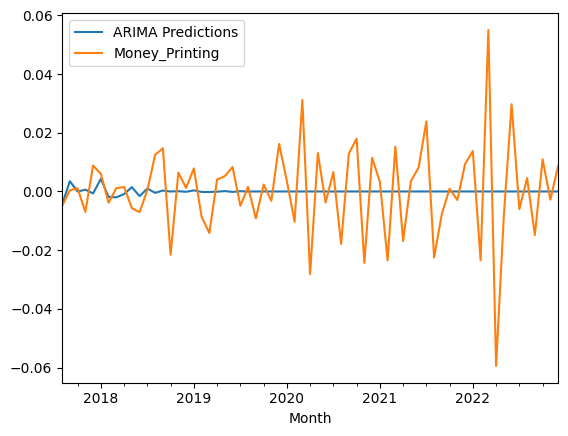

In [16]:
start=len(train)
end=len(train)+len(test)-1
pred=fitted_model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test.plot(legend=True)

Lets measure the accuracy of the model.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

test.mean()
rmse=sqrt(mean_squared_error(pred,test))
#print("RMSE : ", rmse)

# Calculate MAPE
mape = np.mean(np.abs((test - pred) / test)) * 100

# Calculate MAE
mae = mean_absolute_error(test, pred)


print("RMSE : ", rmse)
print("MAPE : ", mape)
print("MAE : ", mae)


RMSE :  0.016058778733352562
MAPE :  111.29661183372033
MAE :  0.01142810159184032


Lets predict values for next 5 years.

<Axes: >

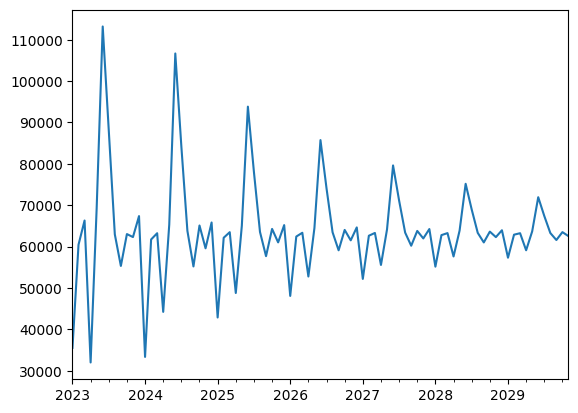

In [ ]:
import pandas as pd
import pickle

start_date = '2023-01-01'
end_date = '2029-12-01'

# Generate monthly date range
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

# Predict future values
predictions_future = fitted_model.get_forecast(steps=len(date_range))
predicted_values_diff = predictions_future.predicted_mean

# Reverse the differencing process
base_value = df['Money_Printing'].iloc[-1]  # Replace 'diff' with the appropriate column name
predicted_values_cumsum = predicted_values_diff.cumsum()
predicted_values_actual = base_value + predicted_values_cumsum

# Set the index as the date range
predicted_values_actual.index = date_range

# Save the predictions to a CSV file
predicted_values_actual.to_csv('Sarima_monetary_financing_6year_predic.csv')

# Plot the predicted values
predicted_values_actual.plot()
